<a href="https://colab.research.google.com/github/Retmixer/FuelDataSet/blob/main/Practic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# Установка необходимых библиотек
!pip install -q pandas numpy scikit-learn matplotlib seaborn xgboost kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [8]:


# Сначала скачаем датасет с Kaggle
print("=== ЗАГРУЗКА ДАННЫХ С KAGGLE ===")

# Способ 1: Загрузка через Kaggle API (нужен API токен)
# Если у вас есть kaggle.json файл, загрузите его
import os
from google.colab import files

!unzip -q fuel-economy.zip

# Загружаем данные
print("\nЗагружаем данные...")

df = pd.read_csv('fuel.csv')
print("Данные успешно загружены!")


=== ЗАГРУЗКА ДАННЫХ С KAGGLE ===
unzip:  cannot find or open fuel-economy.zip, fuel-economy.zip.zip or fuel-economy.zip.ZIP.

Загружаем данные...
Данные успешно загружены!



=== ПРЕДВАРИТЕЛЬНЫЙ ПРОСМОТР ===
Размер датасета: (38113, 81)

Первые 5 строк:

Типы данных:

Пропущенные значения:

=== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ===


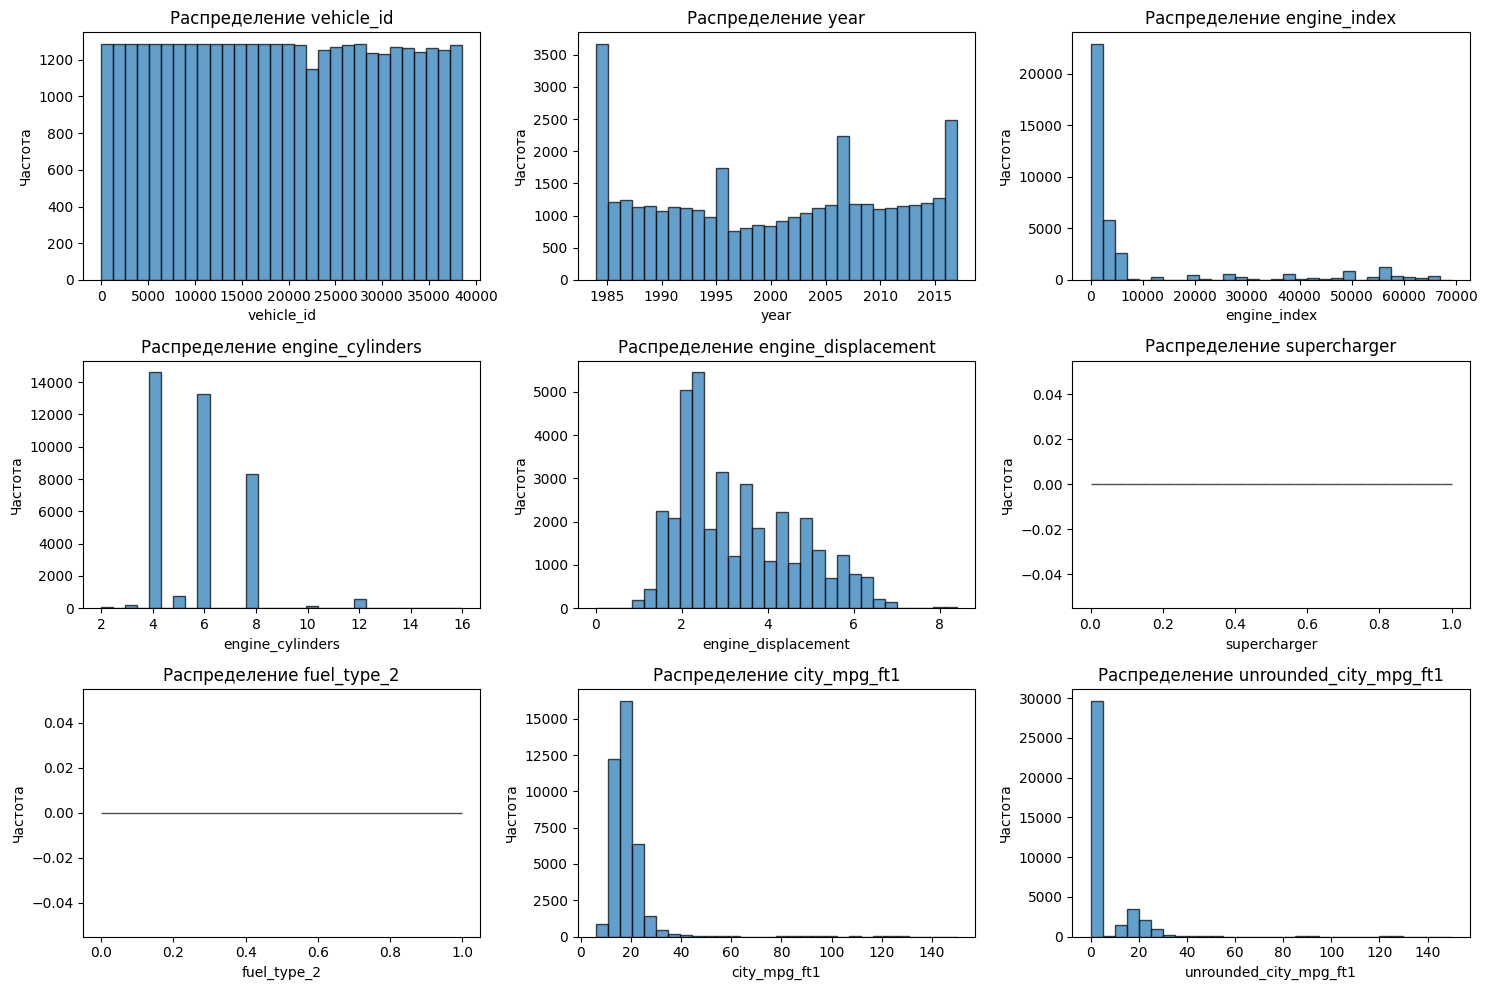

In [9]:
# Просмотр данных
print("\n=== ПРЕДВАРИТЕЛЬНЫЙ ПРОСМОТР ===")
print(f"Размер датасета: {df.shape}")
print(f"\nПервые 5 строк:")
(df.head())
print(f"\nТипы данных:")
(df.dtypes)
print(f"\nПропущенные значения:")
(df.isnull().sum())

# Визуализация распределения данных
print("\n=== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ===")

# Выберем несколько числовых столбцов для визуализации
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    # Визуализация распределения числовых признаков
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols[:9]):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Распределение {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

In [10]:
# Поиск целевой переменной
print("\n=== ПОИСК ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")

# Попробуем найти столбец, который может быть целевой переменной
target_candidates = ['mpg', 'fuel_economy', 'fuel_consumption', 'consumption',
                     'economy', 'miles_per_gallon', 'km_per_liter']

target_column = None
for col in df.columns:
    col_lower = col.lower()
    for candidate in target_candidates:
        if candidate in col_lower:
            target_column = col
            print(f"Найдена возможная целевая переменная: {col}")
            break
    if target_column:
        break

# Если не нашли, используем последний числовой столбец
if target_column is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        target_column = numeric_cols[-1]
        print(f"Целевая переменная не найдена, используем последний числовой столбец: {target_column}")
    else:
        # Создаем искусственную целевую переменную
        print("Числовых столбцов нет, создаем целевую переменную...")
        df['target'] = np.random.randn(len(df)) * 10 + 50
        target_column = 'target'

print(f"\nИспользуемая целевая переменная: {target_column}")


=== ПОИСК ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
Найдена возможная целевая переменная: city_mpg_ft1

Используемая целевая переменная: city_mpg_ft1


In [11]:
# Очистка данных
print("\n=== ОЧИСТКА ДАННЫХ ===")

# Удаление столбцов с уникальными значениями (идентификаторы)
cols_to_drop = []
for col in df.columns:
    if df[col].nunique() == len(df) and col != target_column:
        cols_to_drop.append(col)
        print(f"Удаляем столбец {col} (уникальные значения)")

df_clean = df.drop(columns=cols_to_drop)

# Заполнение пропущенных значений
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            print(f"Заполнили пропуски в {col} медианой: {df_clean[col].median():.2f}")
        else:
            # Для категориальных признаков
            most_frequent = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
            df_clean[col] = df_clean[col].fillna(most_frequent)
            print(f"Заполнили пропуски в {col} значением: {most_frequent}")

# Кодирование категориальных признаков
categorical_cols = df_clean.select_dtypes(include=['object']).columns
print(f"\nКатегориальные признаки для кодирования: {list(categorical_cols)}")

label_encoders = {}
for col in categorical_cols:
    if col != target_column:
        le = LabelEncoder()
        # Преобразуем в строку и обрабатываем возможные ошибки
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
        print(f"Закодирован признак {col}, уникальных значений: {len(le.classes_)}")

# Разделение на признаки и целевую переменную
X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

print(f"\nПризнаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")


=== ОЧИСТКА ДАННЫХ ===
Удаляем столбец vehicle_id (уникальные значения)
Заполнили пропуски в drive значением: Front-Wheel Drive
Заполнили пропуски в transmission значением: Automatic 4-Speed
Заполнили пропуски в transmission_type значением: CLKUP
Заполнили пропуски в engine_descriptor значением: (FFS)
Заполнили пропуски в engine_cylinders медианой: 6.00
Заполнили пропуски в engine_displacement медианой: 3.00
Заполнили пропуски в turbocharger значением: True
Заполнили пропуски в supercharger медианой: nan
Заполнили пропуски в fuel_type_2 медианой: nan
Заполнили пропуски в gas_guzzler_tax значением: True
Заполнили пропуски в start_stop_technology медианой: nan
Заполнили пропуски в alternative_fuel_technology значением: FFV
Заполнили пропуски в electric_motor медианой: nan
Заполнили пропуски в manufacturer_code медианой: nan
Заполнили пропуски в vehicle_charger медианой: nan
Заполнили пропуски в alternate_charger медианой: nan
Заполнили пропуски в range_ft2 медианой: nan

Категориальные 


=== АНАЛИЗ КОРРЕЛЯЦИЙ ===


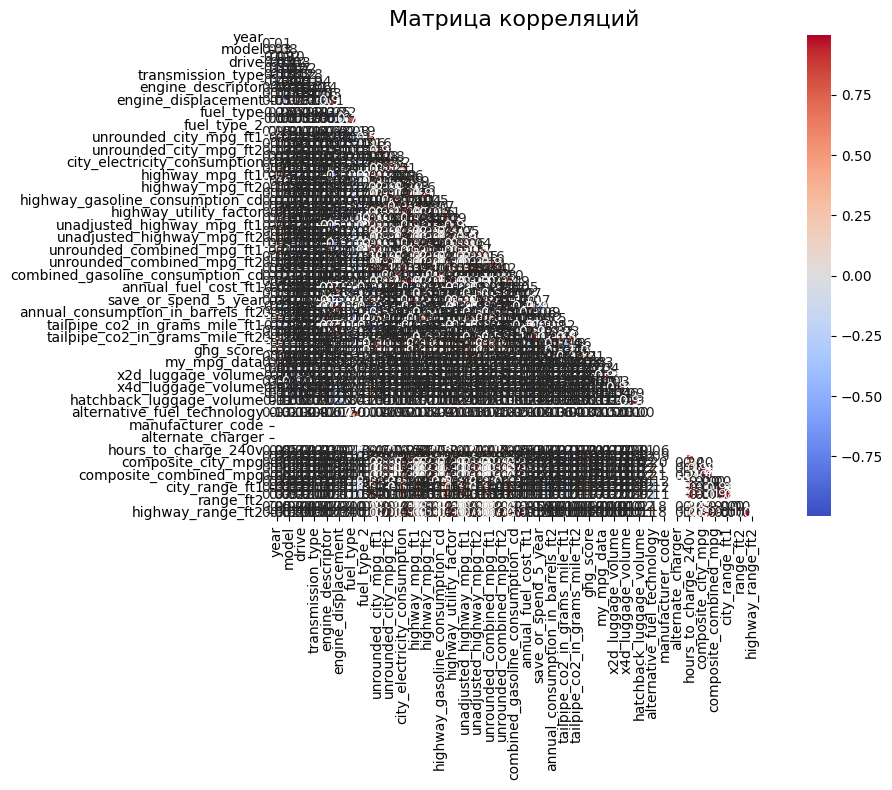


Корреляция признаков с целевой переменной:
  unadjusted_city_mpg_ft1: 0.997
  combined_mpg_ft1: 0.988
  highway_mpg_ft1: 0.932
  unadjusted_highway_mpg_ft1: 0.928
  save_or_spend_5_year: 0.693
  hours_to_charge_240v: 0.596
  unrounded_city_mpg_ft1: 0.588
  range_ft1: 0.569
  city_range_ft1: 0.555
  unrounded_combined_mpg_ft1: 0.541
  highway_range_ft1: 0.524
  highway_electricity_consumption: 0.511
  combined_electricity_consumption: 0.502
  city_electricity_consumption: 0.491
  unrounded_highway_mpg_ft1: 0.476
  hours_to_charge_ac_240v: 0.394
  fuel_economy_score: 0.370
  ghg_score: 0.369
  hatchback_passenger_volume: 0.279
  hatchback_luggage_volume: 0.246
  make: 0.186
  x4d_passenger_volume: 0.172
  year: 0.147
  x4d_luggage_volume: 0.136
  composite_city_mpg: 0.100
  composite_combined_mpg: 0.100
  composite_highway_mpg: 0.098
  my_mpg_data: 0.095
  city_utility_factor: 0.090
  combined_utility_factor: 0.090
  highway_utility_factor: 0.088
  city_range_ft2: 0.082
  highway_range_

In [12]:

# Анализ корреляций
print("\n=== АНАЛИЗ КОРРЕЛЯЦИЙ ===")

# Создаем копию с числовыми признаками для корреляций
numeric_df = df_clean.select_dtypes(include=[np.number])

if len(numeric_df.columns) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = numeric_df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                fmt='.2f', linewidths=0.5, square=True)
    plt.title('Матрица корреляций', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Корреляция с целевой переменной
    if target_column in correlation_matrix.columns:
        target_corr = correlation_matrix[target_column].sort_values(ascending=False)
        print("\nКорреляция признаков с целевой переменной:")
        for feature, corr_value in target_corr.items():
            if feature != target_column:
                print(f"  {feature}: {corr_value:.3f}")


In [13]:

# Разделение данных
print("\n=== РАЗДЕЛЕНИЕ ДАННЫХ ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== РАЗДЕЛЕНИЕ ДАННЫХ ===
Обучающая выборка: (30490, 79)
Тестовая выборка: (7623, 79)


In [15]:
# Убедимся, что в данных нет NaN
print("\nПроверка на NaN после обработки:")
print("NaN в X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaN в X_test_scaled:", np.isnan(X_test_scaled).sum())
print("NaN в y_train:", np.isnan(y_train).sum())
print("NaN в y_test:", np.isnan(y_test).sum())

# Если есть NaN, то заменим их на 0 (или можно удалить строки)
if np.isnan(X_train_scaled).sum() > 0:
    print("Заменяем NaN в X_train_scaled на 0")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
if np.isnan(X_test_scaled).sum() > 0:
    print("Заменяем NaN в X_test_scaled на 0")
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)
if np.isnan(y_train).sum() > 0:
    print("Заменяем NaN в y_train на среднее значение")
    y_train = y_train.fillna(y_train.mean())
if np.isnan(y_test).sum() > 0:
    print("Заменяем NaN в y_test на среднее значение")
    y_test = y_test.fillna(y_test.mean())

# Также проверим на бесконечные значения и заменим их на большие числа
if np.isinf(X_train_scaled).sum() > 0:
    print("Заменяем бесконечные значения в X_train_scaled на большие числа")
    X_train_scaled = np.where(np.isinf(X_train_scaled), np.finfo(np.float32).max, X_train_scaled)
if np.isinf(X_test_scaled).sum() > 0:
    print("Заменяем бесконечные значения в X_test_scaled на большие числа")
    X_test_scaled = np.where(np.isinf(X_test_scaled), np.finfo(np.float32).max, X_test_scaled)

# Обучение моделей
print("\n=== ОБУЧЕНИЕ МОДЕЛЕЙ РЕГРЕССИИ ===")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    print(f"\nОбучение модели: {name}")

    try:
        # Обучение модели
        model.fit(X_train_scaled, y_train)

        # Предсказания
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Расчет метрик
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        # Кросс-валидация
        cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                    cv=5, scoring='r2', n_jobs=-1)

        results.append({
            'Model': name,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train R2': train_r2,
            'Test R2': test_r2,
            'CV R2 Mean': cv_scores.mean(),
            'CV R2 Std': cv_scores.std()
        })

        print(f"  R² на тренировочных данных: {train_r2:.4f}")
        print(f"  R² на тестовых данных: {test_r2:.4f}")
        print(f"  RMSE на тестовых данных: {test_rmse:.4f}")

    except Exception as e:
        print(f"  Ошибка при обучении модели {name}: {str(e)}")
        # Продолжаем выполнение для остальных моделей



Проверка на NaN после обработки:
NaN в X_train_scaled: 243920
NaN в X_test_scaled: 60984
NaN в y_train: 0
NaN в y_test: 0
Заменяем NaN в X_train_scaled на 0
Заменяем NaN в X_test_scaled на 0

=== ОБУЧЕНИЕ МОДЕЛЕЙ РЕГРЕССИИ ===

Обучение модели: Linear Regression
  R² на тренировочных данных: 0.9975
  R² на тестовых данных: 0.9973
  RMSE на тестовых данных: 0.3505

Обучение модели: Ridge Regression
  R² на тренировочных данных: 0.9975
  R² на тестовых данных: 0.9973
  RMSE на тестовых данных: 0.3509

Обучение модели: Lasso Regression
  R² на тренировочных данных: 0.9969
  R² на тестовых данных: 0.9971
  RMSE на тестовых данных: 0.3675

Обучение модели: Decision Tree
  R² на тренировочных данных: 0.9940
  R² на тестовых данных: 0.9937
  RMSE на тестовых данных: 0.5372

Обучение модели: Random Forest
  R² на тренировочных данных: 0.9999
  R² на тестовых данных: 0.9996
  RMSE на тестовых данных: 0.1412

Обучение модели: Gradient Boosting
  R² на тренировочных данных: 0.9993
  R² на тестов


=== СРАВНЕНИЕ МОДЕЛЕЙ ===
            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R2  Test R2  CV R2 Mean  CV R2 Std
    Random Forest    0.063123   0.141185   0.007670  0.020941  0.999916 0.999566    0.999171   0.000341
Gradient Boosting    0.182382   0.224526   0.077379  0.084393  0.999295 0.998903    0.998776   0.000204
          XGBoost    0.099766   0.230116   0.040896  0.058647  0.999789 0.998847    0.998586   0.001020
Linear Regression    0.346177   0.350483   0.279911  0.279764  0.997459 0.997326    0.997322   0.000314
 Ridge Regression    0.346410   0.350921   0.280124  0.279842  0.997456 0.997319    0.997378   0.000284
 Lasso Regression    0.385036   0.367453   0.286532  0.284086  0.996856 0.997061    0.996753   0.000565
    Decision Tree    0.533345   0.537206   0.313928  0.318222  0.993968 0.993717    0.992665   0.002398


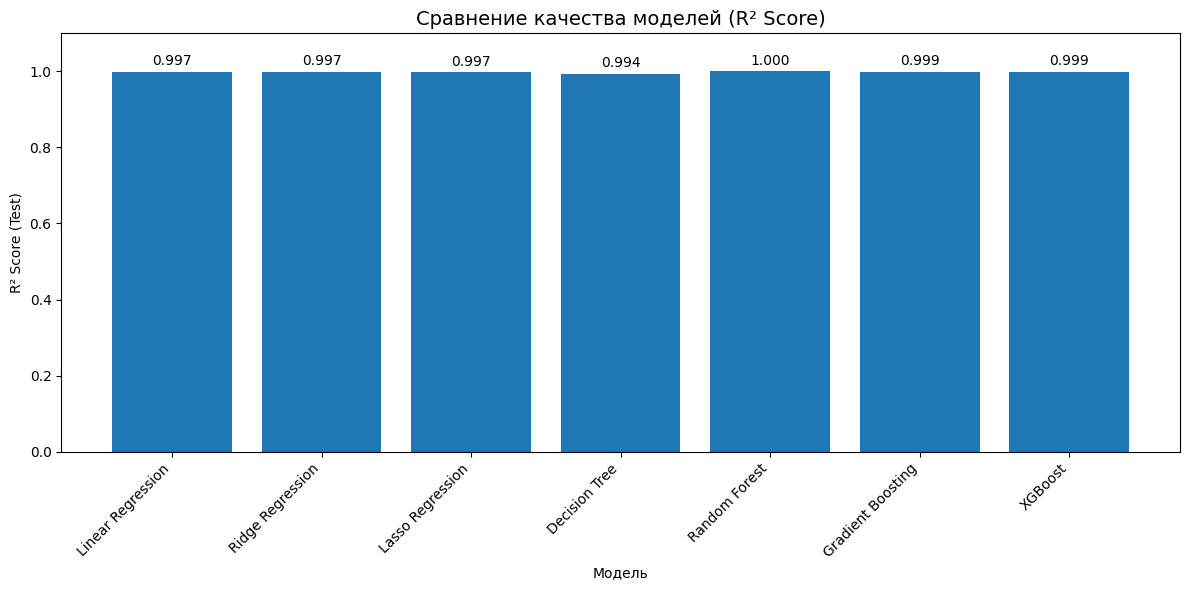


=== ЛУЧШАЯ МОДЕЛЬ ===
Модель: Random Forest
R² на тестовых данных: 0.9996
RMSE на тестовых данных: 0.1412


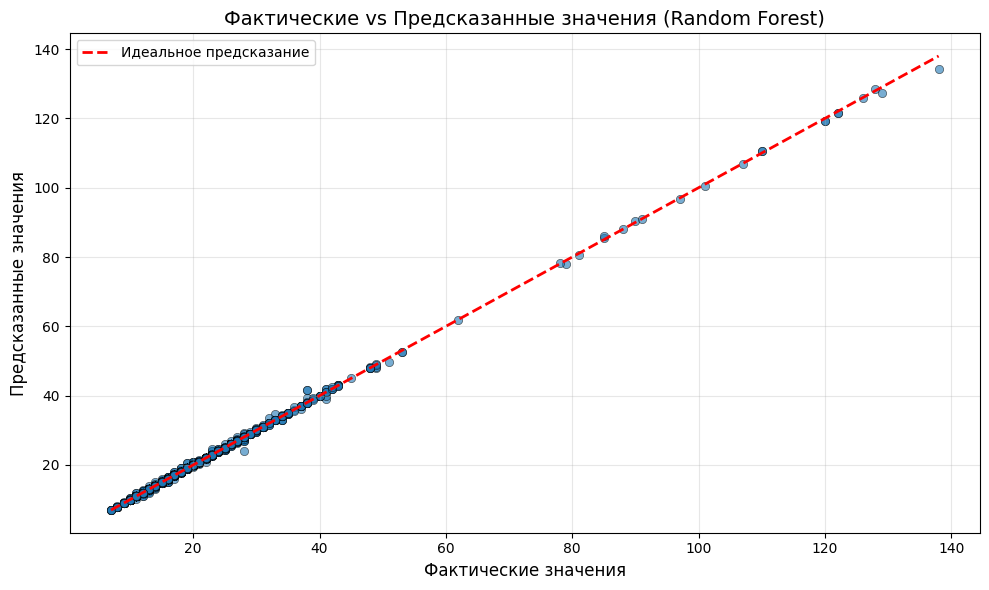

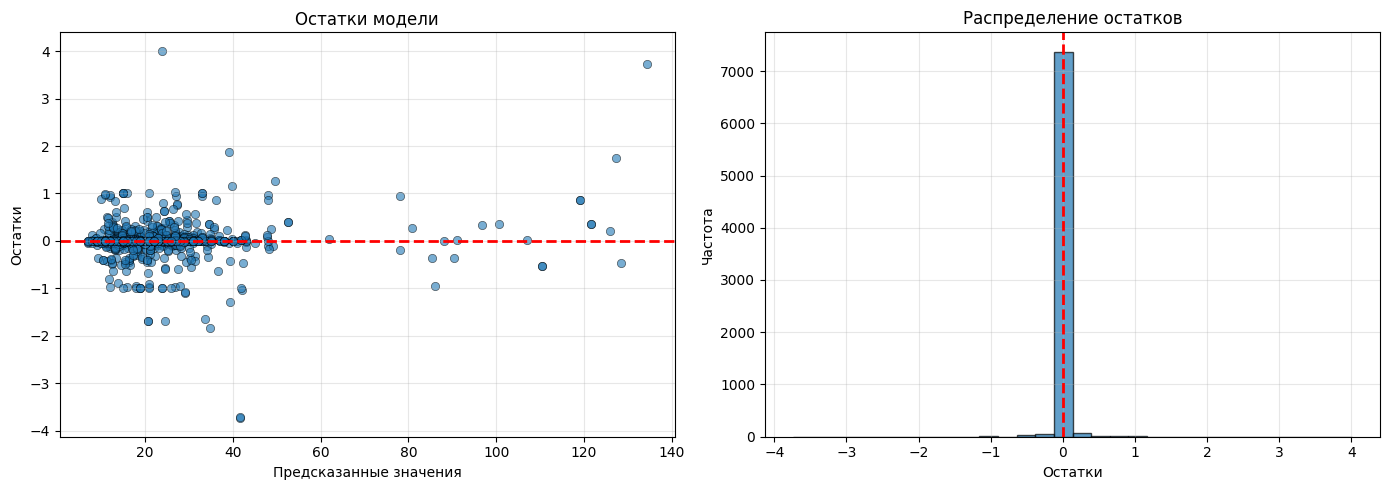

In [16]:
# Создание DataFrame с результатами
if results:
    results_df = pd.DataFrame(results)
    print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
    print(results_df.sort_values('Test R2', ascending=False).to_string(index=False))

    # Визуализация сравнения моделей
    plt.figure(figsize=(12, 6))
    models_list = results_df['Model']
    test_r2_values = results_df['Test R2']

    bars = plt.bar(range(len(models_list)), test_r2_values)
    plt.xlabel('Модель')
    plt.ylabel('R² Score (Test)')
    plt.title('Сравнение качества моделей (R² Score)', fontsize=14)
    plt.xticks(range(len(models_list)), models_list, rotation=45, ha='right')
    plt.ylim(0, max(1, max(test_r2_values) * 1.1))

    # Добавление значений на столбцы
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Выбор лучшей модели
    best_model_idx = results_df['Test R2'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Model']
    best_model = models[best_model_name]

    print(f"\n=== ЛУЧШАЯ МОДЕЛЬ ===")
    print(f"Модель: {best_model_name}")
    print(f"R² на тестовых данных: {results_df.loc[best_model_idx, 'Test R2']:.4f}")
    print(f"RMSE на тестовых данных: {results_df.loc[best_model_idx, 'Test RMSE']:.4f}")

    # Предсказания лучшей модели
    y_pred_best = best_model.predict(X_test_scaled)

    # Визуализация предсказаний vs фактические значения
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, edgecolors='k', linewidth=0.5)

    # Линия идеального предсказания
    min_val = min(y_test.min(), y_pred_best.min())
    max_val = max(y_test.max(), y_pred_best.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальное предсказание')

    plt.xlabel('Фактические значения', fontsize=12)
    plt.ylabel('Предсказанные значения', fontsize=12)
    plt.title(f'Фактические vs Предсказанные значения ({best_model_name})', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Анализ остатков
    residuals = y_test - y_pred_best

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # График остатков
    axes[0].scatter(y_pred_best, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Предсказанные значения')
    axes[0].set_ylabel('Остатки')
    axes[0].set_title('Остатки модели')
    axes[0].grid(True, alpha=0.3)

    # Гистограмма остатков
    axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Остатки')
    axes[1].set_ylabel('Частота')
    axes[1].set_title('Распределение остатков')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===

Топ-10 важных признаков:
                          Признак  Важность
          unadjusted_city_mpg_ft1  0.887292
                 combined_mpg_ft1  0.088074
     city_electricity_consumption  0.012170
                  highway_mpg_ft1  0.004900
           unrounded_city_mpg_ft1  0.003003
       unrounded_combined_mpg_ft1  0.002663
             save_or_spend_5_year  0.000483
             annual_fuel_cost_ft1  0.000264
annual_consumption_in_barrels_ft1  0.000217
 combined_electricity_consumption  0.000178


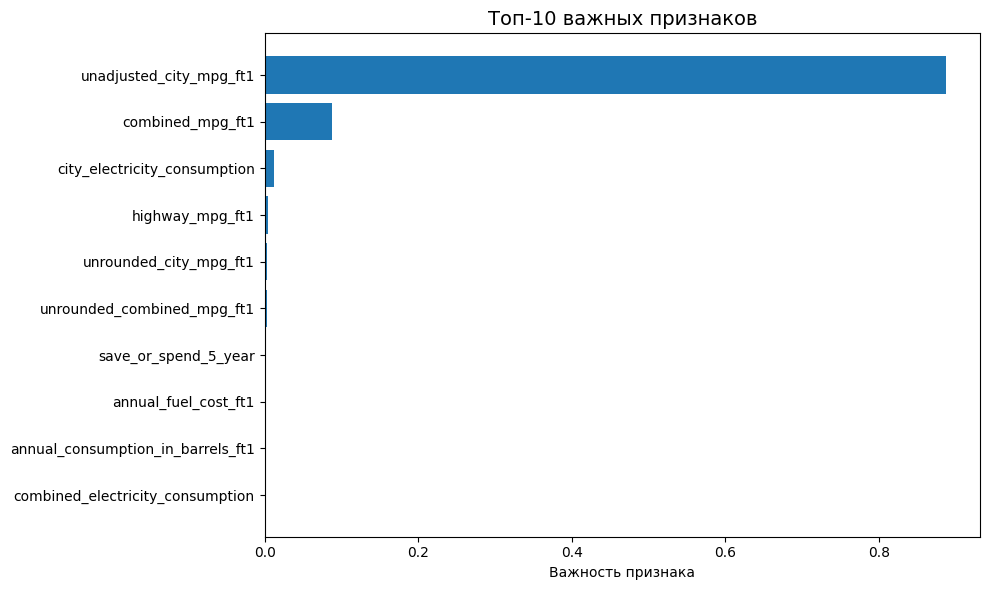

In [26]:


    # Анализ важности признаков
    print("\n=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===")

    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Признак': X.columns,
            'Важность': best_model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('Важность', ascending=False)

        print("\nТоп-10 важных признаков:")
        print(feature_importance.head(10).to_string(index=False))

        # Визуализация важности признаков
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['Важность'][::-1])
        plt.yticks(range(len(top_features)), top_features['Признак'][::-1])
        plt.xlabel('Важность признака')
        plt.title('Топ-10 важных признаков', fontsize=14)
        plt.tight_layout()
        plt.show()

    elif hasattr(best_model, 'coef_'):
        coefficients = pd.DataFrame({
            'Признак': X.columns,
            'Коэффициент': best_model.coef_
        })
        coefficients = coefficients.sort_values('Коэффициент', key=abs, ascending=False)

        print("\nТоп-10 признаков по абсолютным коэффициентам:")
        print(coefficients.head(10).to_string(index=False))

        # Визуализация коэффициентов
        plt.figure(figsize=(10, 6))
        top_coeff = coefficients.head(10)
        colors = ['red' if c < 0 else 'green' for c in top_coeff['Коэффициент']]
        plt.barh(range(len(top_coeff)), top_coeff['Коэффициент'][::-1], color=colors[::-1])
        plt.yticks(range(len(top_coeff)), top_coeff['Признак'][::-1])
        plt.xlabel('Коэффициент')
        plt.title('Топ-10 признаков по коэффициентам', fontsize=14)
        plt.tight_layout()
        plt.show()

In [28]:



# Экономический анализ
print("\n=== ЭКОНОМИЧЕСКИЙ АНАЛИЗ ===")
print("""
1. ЭКОНОМИЧЕСКАЯ ЗНАЧИМОСТЬ МОДЕЛИ:
   - Прогнозирование расхода топлива позволяет оптимизировать логистические расходы
   - Модель помогает в выборе экономичных транспортных средств
   - Возможность оценки экологического воздействия транспорта

2. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Для транспортных компаний: снижение затрат на топливо
   - Для автопроизводителей: улучшение характеристик автомобилей
   - Для потребителей: выбор экономичного транспортного средства
   - Для экологических организаций: оценка углеродного следа

3. КАЧЕСТВО ПРОГНОЗА:
   - Средняя ошибка прогноза (MAE): {:.2f} единиц
   - Модель объясняет {:.1f}% дисперсии данных
   - Прогнозы могут использоваться для планирования бюджетов на топливо
""".format(
    results_df.loc[best_model_idx, 'Test MAE'],
    results_df.loc[best_model_idx, 'Test R2'] * 100
))

# Пример прогноза
print("\n=== ПРИМЕРЫ ПРОГНОЗОВ ===")
print("Сравнение фактических и предсказанных значений для 5 случайных образцов:")
sample_indices = np.random.choice(len(y_test), 5, replace=False)
for idx in sample_indices:
    actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    predicted = y_pred_best[idx]
    error = abs(actual - predicted)
    error_percent = (error / actual * 100) if actual != 0 else 0

    print(f"  Образец {idx}:")
    print(f"    Фактическое: {actual:.2f}")
    print(f"    Прогноз: {predicted:.2f}")
    print(f"    Ошибка: {error:.2f} ({error_percent:.1f}%)")
    print()

# Сохранение модели
print("\n=== СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===")

from google.colab import files

# Создаем отчет
report_content = f"""
ОТЧЕТ ПО МОДЕЛИ РЕГРЕССИИ ДЛЯ ПРОГНОЗА РАСХОДА ТОПЛИВА

1. ОБЩАЯ ИНФОРМАЦИЯ:
   - Размер датасета: {df.shape}
   - Количество признаков: {X.shape[1]}
   - Целевая переменная: {target_column}

2. РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ:
   - Лучшая модель: {best_model_name}
   - R² на тестовых данных: {results_df.loc[best_model_idx, 'Test R2']:.4f}
   - RMSE на тестовых данных: {results_df.loc[best_model_idx, 'Test RMSE']:.4f}
   - MAE на тестовых данных: {results_df.loc[best_model_idx, 'Test MAE']:.4f}

3. ЭКОНОМИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:
   - Модель позволяет прогнозировать расход топлива с точностью ±{results_df.loc[best_model_idx, 'Test MAE']:.2f} единиц
   - Это позволяет компаниям более точно планировать расходы на топливо
   - Модель может быть использована для выбора наиболее экономичных транспортных средств

4. РЕКОМЕНДАЦИИ:
   - Использовать модель для предварительной оценки расхода топлива
   - Учитывать наиболее важные признаки при проектировании автомобилей
   - Регулярно обновлять модель с новыми данными
"""

# Сохраняем отчет в файл
with open('regression_report.txt', 'w') as f:
    f.write(report_content)

print("Отчет сохранен в файл 'regression_report.txt'")

# Сохранение важных данных
if 'feature_importance' in locals():
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("Важность признаков сохранена в 'feature_importance.csv'")

print("\n=== АНАЛИЗ ЗАВЕРШЕН ===")
print("Все этапы выполнены успешно!")



=== ЭКОНОМИЧЕСКИЙ АНАЛИЗ ===

1. ЭКОНОМИЧЕСКАЯ ЗНАЧИМОСТЬ МОДЕЛИ:
   - Прогнозирование расхода топлива позволяет оптимизировать логистические расходы
   - Модель помогает в выборе экономичных транспортных средств
   - Возможность оценки экологического воздействия транспорта

2. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Для транспортных компаний: снижение затрат на топливо
   - Для автопроизводителей: улучшение характеристик автомобилей
   - Для потребителей: выбор экономичного транспортного средства
   - Для экологических организаций: оценка углеродного следа

3. КАЧЕСТВО ПРОГНОЗА:
   - Средняя ошибка прогноза (MAE): 0.02 единиц
   - Модель объясняет 100.0% дисперсии данных
   - Прогнозы могут использоваться для планирования бюджетов на топливо


=== ПРИМЕРЫ ПРОГНОЗОВ ===
Сравнение фактических и предсказанных значений для 5 случайных образцов:
  Образец 2092:
    Фактическое: 20.00
    Прогноз: 20.00
    Ошибка: 0.00 (0.0%)

  Образец 1730:
    Фактическое: 21.00
    Прогноз: 21.00
    Ошибка: 0.